In [1]:
!pip install -U albumentations opencv-python
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4403b052977f05d1c8ebc2d98813c419335bf3ba184d71c4e0e3663ea4b214cb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=7372d7a2601c62314

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Импортируем все необходимые библиотеки

In [3]:
import tarfile
import pandas as pd
import zipfile
from zipfile import ZipFile
import os
from random import sample
from os import listdir
import cv2
import numpy as np
from tqdm import tqdm
import time
from tempfile import TemporaryDirectory
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Подгружаем текущий датасет, с которым работаем

In [5]:
!cp /content/drive/MyDrive/skoltech_hack/data/dataset_egy_inria.zip .

file_name = "dataset_egy_inria.zip"
with ZipFile(file_name, 'r') as zip:

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


In [6]:
!ls dataset_egy_inria/inria

256


Данный датасет объединяет в себе два, формируем датафрейм с полями: путь к изображению и путь к его маске

In [7]:
images_1_dir = "./dataset_egy_inria/EGY_BCD/256/images/"
masks_1_dir = "./dataset_egy_inria/EGY_BCD/256/masks/"
names_1 = listdir(images_1_dir)
# masks = listdir("./EGY_BCD/label")

data_df_1 = pd.DataFrame(
    {
        "img_path": [images_1_dir + name for name in names_1],
        "mask_path": [masks_1_dir + name for name in names_1]
    }
)

In [8]:
images_2_dir = "./dataset_egy_inria/inria/256/images/"
masks_2_dir = "./dataset_egy_inria/inria/256/masks/"
names_2 = listdir(images_2_dir)
# masks = listdir("./EGY_BCD/label")

data_df_2 = pd.DataFrame(
    {
        "img_path": [images_2_dir + name for name in names_2],
        "mask_path": [masks_2_dir + name for name in names_2]
    }
)

In [9]:
data_df = pd.concat([data_df_1, data_df_2])

In [10]:
data_df.sample(4)

,img_path,mask_path
5318,./dataset_egy_inria/inria/256/images/27_chicag...,./dataset_egy_inria/inria/256/masks/27_chicago...
3078,./dataset_egy_inria/inria/256/images/22_kitsap...,./dataset_egy_inria/inria/256/masks/22_kitsap1...
1443,./dataset_egy_inria/EGY_BCD/256/images/Galala_...,./dataset_egy_inria/EGY_BCD/256/masks/Galala_1...
582,./dataset_egy_inria/EGY_BCD/256/images/Tiba_7_...,./dataset_egy_inria/EGY_BCD/256/masks/Tiba_7_2...


Разбиваем на обучение и валидацию

In [11]:
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=121212)

Задаем трансформации

In [12]:
transform_train = A.Compose([

    A.RandomRotate90(p=1),
    A.Normalize(),
    A.Resize(256, 256),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Normalize(),
    A.Resize(256, 256),
    ToTensorV2()
])

Кастомный датасет для взаимодействия с изображениями

In [13]:
class BuildingDataset(Dataset):
  def __init__(self, df, transforms=None):
    self.df = df
    self.transforms = transforms

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx].img_path
    mask_path = self.df.iloc[idx].mask_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.float32(mask / 255)

    if self.transforms:
      aug = self.transforms(image=img, mask=mask)
      img = aug["image"]
      mask = aug["mask"]

    return img, mask

  def __len__(self):
    return len(self.df)

In [14]:
train_dataset = BuildingDataset(train_df, transform_train)
val_dataset = BuildingDataset(val_df, transform_val)

image_datasets = {
    "train": train_dataset,
    "val": val_dataset,
}

In [15]:
dataloaders = {
    data_type: DataLoader(
        image_datasets[data_type],
        batch_size=16,
        shuffle=True
        )
    for data_type in ["train", "val"]
}

dataset_sizes = {
    data_type: len(image_datasets[data_type]) for data_type in ['train', 'val']
    }

Функция для обучения модели

In [25]:
def train(model, criterion, optimizer, scheduler=None, num_epochs=5, save_path="./fpn_pretr.pt"):
    since = time.time()

    best_model_params_path = save_path

    torch.save(model.state_dict(), best_model_params_path)
    best_iou = 0.0
    best_f1 = 0.0
    best_loss = np.inf

    train_loss_lst = []
    val_loss_lst = []
    metric_f1_lst = []
    metric_iou_lst = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ["train", "val"]:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_iou = 0
            running_f1 = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                inputs = inputs.float()
                labels = labels.to(device)

                # labels = torch.permute(labels, (0, 3, 1, 2))
                # inputs = torch.permute(inputs, (0, 3, 1, 2))
                labels = labels[:, np.newaxis, :, :]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print()
                    # print(f"outputs: {outputs.shape}")
                    # print(f"labels: {labels.shape}")
                    loss = criterion(outputs, labels)
                    # print(f"loss: {loss.item()}")

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # print()
                # print(f"inputs.size(0): {inputs.size(0)}")
                # print(f"loss: {loss.item()}")
                running_loss += loss.item() * inputs.size(0)
                # print(f"loss.item() * inputs.size(0): {loss.item() * inputs.size(0)}")

                if phase == "val":
                    y_pred = F.sigmoid(outputs)

                    # val_iou = iou_coef(labels, y_pred).cpu().detach().numpy()
                    tp, fp, fn, tn = smp.metrics.get_stats(y_pred, labels.long(), mode="binary", threshold=0.5)
                    val_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
                    val_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
                    running_iou += val_iou
                    running_f1 += val_f1

            if phase == 'train' and (not (scheduler is None)):
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == "val":
                epoch_iou = running_iou / len(dataloaders[phase])
                print(f'{phase} IOU: {epoch_iou:.4f}')
                epoch_f1 = running_f1 / len(dataloaders[phase])
                print(f'{phase} F1: {epoch_f1:.4f}')
                metric_iou_lst.append(epoch_iou)
                metric_f1_lst.append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            if phase == "train":
              train_loss_lst.append(epoch_loss)
            elif phase == "val":
              val_loss_lst.append(epoch_loss)

            # deep copy the model
            if phase == 'val':
                if epoch_iou > best_iou:
                    best_iou = epoch_iou
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1

            if phase == "val" and epoch_loss < best_loss:
                torch.save(model.state_dict(), best_model_params_path)
                torch.save(model.state_dict(), "/content/drive/MyDrive/fpn_pretr.pt")
                best_loss = epoch_loss



    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')
    print(f'Best val IOU: {best_iou:4f}')
    print(f'Best val F1: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, {
        "train_loss": train_loss_lst,
        "val_loss": val_loss_lst,
        "metric_f1": metric_f1_lst,
        "metric_iou": metric_iou_lst
    }

In [26]:
model = smp.FPN()
model.to(device)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [27]:
criterion = smp.losses.DiceLoss(mode="binary")
optimizer = optim.AdamW(model.parameters())

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [28]:
res_model, proc_dict = train(model, criterion, optimizer, num_epochs=15)

Epoch 0/14
----------


100%|██████████| 434/434 [01:38<00:00,  4.42it/s]


train Loss: 0.4008


100%|██████████| 109/109 [00:14<00:00,  7.74it/s]


val IOU: 0.4931
val F1: 0.6593
val Loss: 0.3422
Epoch 1/14
----------


100%|██████████| 434/434 [01:36<00:00,  4.50it/s]


train Loss: 0.3161


100%|██████████| 109/109 [00:12<00:00,  8.77it/s]


val IOU: 0.5373
val F1: 0.6980
val Loss: 0.3035
Epoch 2/14
----------


100%|██████████| 434/434 [01:34<00:00,  4.57it/s]


train Loss: 0.2910


100%|██████████| 109/109 [00:13<00:00,  8.38it/s]


val IOU: 0.5677
val F1: 0.7229
val Loss: 0.2787
Epoch 3/14
----------


100%|██████████| 434/434 [01:34<00:00,  4.58it/s]


train Loss: 0.2807


100%|██████████| 109/109 [00:12<00:00,  8.90it/s]


val IOU: 0.5584
val F1: 0.7153
val Loss: 0.2863
Epoch 4/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.55it/s]


train Loss: 0.2734


100%|██████████| 109/109 [00:13<00:00,  8.32it/s]


val IOU: 0.5892
val F1: 0.7403
val Loss: 0.2613
Epoch 5/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.53it/s]


train Loss: 0.2643


100%|██████████| 109/109 [00:12<00:00,  8.74it/s]


val IOU: 0.5591
val F1: 0.7158
val Loss: 0.2856
Epoch 6/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.54it/s]


train Loss: 0.2603


100%|██████████| 109/109 [00:13<00:00,  8.21it/s]


val IOU: 0.5672
val F1: 0.7222
val Loss: 0.2854
Epoch 7/14
----------


100%|██████████| 434/434 [01:36<00:00,  4.51it/s]


train Loss: 0.2475


100%|██████████| 109/109 [00:12<00:00,  8.56it/s]


val IOU: 0.6055
val F1: 0.7529
val Loss: 0.2487
Epoch 8/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.55it/s]


train Loss: 0.2422


100%|██████████| 109/109 [00:12<00:00,  8.49it/s]


val IOU: 0.6052
val F1: 0.7525
val Loss: 0.2483
Epoch 9/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.52it/s]


train Loss: 0.2469


100%|██████████| 109/109 [00:13<00:00,  8.33it/s]


val IOU: 0.6122
val F1: 0.7582
val Loss: 0.2426
Epoch 10/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.56it/s]


train Loss: 0.2602


100%|██████████| 109/109 [00:12<00:00,  8.76it/s]


val IOU: 0.5896
val F1: 0.7405
val Loss: 0.2629
Epoch 11/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.53it/s]


train Loss: 0.2481


100%|██████████| 109/109 [00:13<00:00,  8.27it/s]


val IOU: 0.6132
val F1: 0.7591
val Loss: 0.2422
Epoch 12/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.52it/s]


train Loss: 0.2348


100%|██████████| 109/109 [00:12<00:00,  8.76it/s]


val IOU: 0.6248
val F1: 0.7679
val Loss: 0.2329
Epoch 13/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.52it/s]


train Loss: 0.2319


100%|██████████| 109/109 [00:13<00:00,  8.32it/s]


val IOU: 0.6276
val F1: 0.7699
val Loss: 0.2308
Epoch 14/14
----------


100%|██████████| 434/434 [01:35<00:00,  4.52it/s]


train Loss: 0.2278


100%|██████████| 109/109 [00:12<00:00,  8.63it/s]


val IOU: 0.6270
val F1: 0.7698
val Loss: 0.2311
Training complete in 27m 17s
Best val loss: 0.230757
Best val IOU: 0.627648
Best val F1: 0.769919


Функция ошибка на обучении и валидации

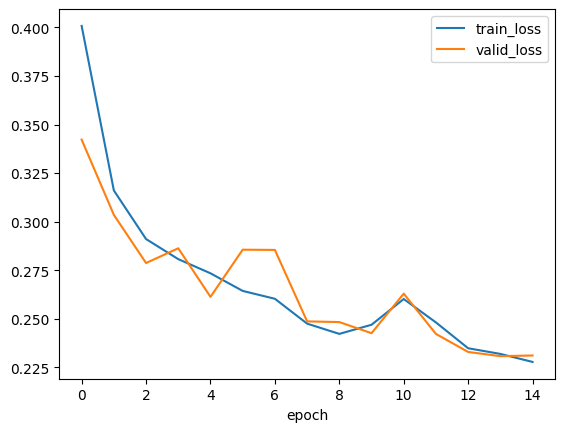

In [29]:
plt.xlabel("epoch")
plt.plot(proc_dict["train_loss"], label="train_loss")
plt.plot(proc_dict["val_loss"], label="valid_loss")
plt.legend()

F1

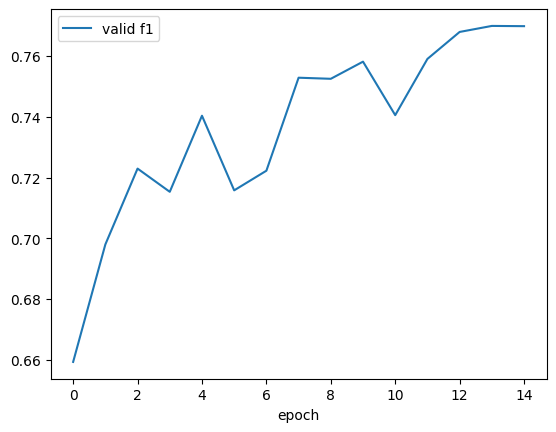

In [30]:
plt.xlabel("epoch")
plt.plot(proc_dict["metric_f1"], label="valid f1")
plt.legend()